## Importação de Bibliotecas

In [45]:
import pandas as pd
import kagglehub
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import accuracy_score, recall_score, classification_report, roc_auc_score
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, GridSearchCV, RandomizedSearchCV
from scipy.stats import entropy, wasserstein_distance, ks_2samp
from scipy.spatial.distance import jensenshannon
import numpy as np
import warnings
from IPython.display import display

warnings.filterwarnings("ignore")
sns.set_theme()

## Definição de Variáveis e Processamento do Dataset

In [ ]:
column_names = [
    "age",
    "sex",
    "chest_pain_type",
    "bp",
    "cholesterol",
    "fbs_over_120",
    "ekg_results",
    "max_hr",
    "exercise_angina",
    "st_depression",
    "slope_of_st",
    "number_of_vessels_fluro",
    "thallium",
    "heart_disease"
]

columns_translated = {
    "age": "Idade",
    "sex": "Sexo",
    "chest_pain_type": "Tipo de Dor no Peito",
    "bp": "Pressão Arterial",
    "cholesterol": "Colesterol",
    "fbs_over_120": "Glicose em Jejum Acima de 120",
    "ekg_results": "Resultados do EKG",
    "max_hr": "Frequência Cardíaca Máxima",
    "exercise_angina": "Angina Induzida por Exercício",
    "st_depression": "Depressão ST",
    "slope_of_st": "Inclinação de ST",
    "number_of_vessels_fluro": "Número de Vasos Fluoroscópicos",
    "thallium": "Talio",
    "heart_disease": "Doença Cardíaca"
}

int_column_names = column_names.copy()
int_column_names.remove('st_depression')
path = r"C:\Users\Lucas\.cache\kagglehub\datasets\rishidamarla\heart-disease-prediction\versions\1"

In [5]:
df = pd.DataFrame(pd.read_csv(path+"\\Heart_Disease_Prediction.csv"))
df.columns = column_names
df['heart_disease'] = np.where(df['heart_disease'] == "Presence",1,0)
df['st_depression'] = df['st_depression'].astype('float32')
df[int_column_names] = df[int_column_names].astype('int16')
df.head()

,age,sex,chest_pain_type,bp,cholesterol,fbs_over_120,ekg_results,max_hr,exercise_angina,st_depression,slope_of_st,number_of_vessels_fluro,thallium,heart_disease
0,70,1,4,130,322,0,2,109,0,2.4,2,3,3,1
1,67,0,3,115,564,0,2,160,0,1.6,2,0,7,0
2,57,1,2,124,261,0,0,141,0,0.3,1,0,7,1
3,64,1,4,128,263,0,0,105,1,0.2,2,1,7,0
4,74,0,2,120,269,0,2,121,1,0.2,1,1,3,0


## Análise de Dados Anteriores ao Treinamento

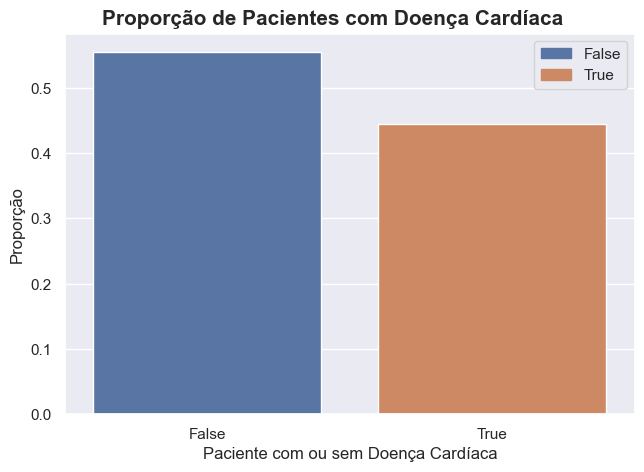

In [101]:
proportions = df['heart_disease'].value_counts(normalize=True)

# Create the countplot and map the colors to the proportions
ax = sns.barplot(x=proportions.index, y=proportions.values)
plt.suptitle('Proporção de Pacientes com Doença Cardíaca', fontsize=15, fontweight='bold')
ax.set_xticklabels(['False', 'True'])
handles = [plt.Rectangle((0,0),1,1, color=ax.patches[0].get_facecolor()),
           plt.Rectangle((0,0),1,1, color=ax.patches[1].get_facecolor())]
plt.legend(handles, ['False', 'True'])
plt.xlabel("Paciente com ou sem Doença Cardíaca")
plt.tight_layout()
plt.subplots_adjust(top=.93)
plt.ylabel("Proporção")
# plt.savefig('plot_porporcao_doenca.png', dpi=300, bbox_inches='tight')
plt.show()

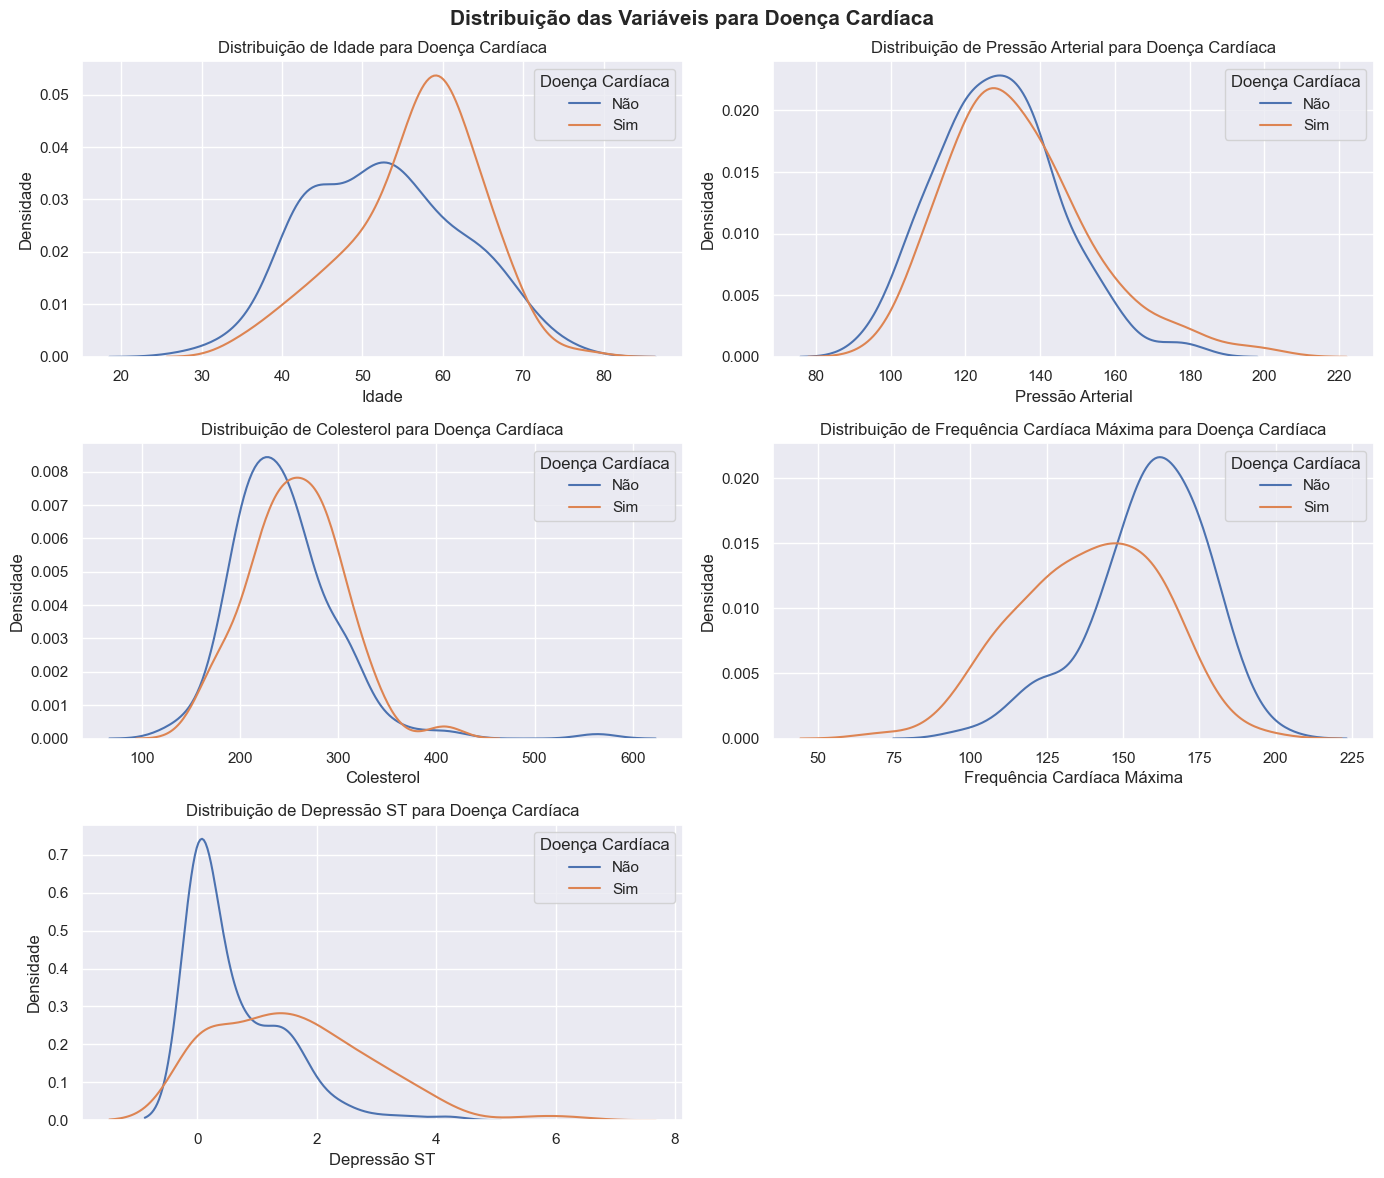

In [48]:
# Define the continuous columns to plot
columns = ["age", "bp", "cholesterol", "max_hr", "st_depression"]

# Calculate the number of rows and columns for the subplots grid
n_rows = (len(columns) + 1) // 2  # Adjust for two columns per row

# Set up the figure and axes
fig, axes = plt.subplots(n_rows, 2, figsize=(14, 4 * n_rows))  # Adjust figsize as needed
axes = axes.flatten()  # Flatten the axes array for easy indexing


# Loop through each column and plot on a subplot
for i, col in enumerate(columns):
    sns.kdeplot(df.loc[df['heart_disease'] == 0, col], label='Doença Cardíaca = 0', ax=axes[i])
    sns.kdeplot(df.loc[df['heart_disease'] == 1, col], label='Doença Cardíaca = 1', ax=axes[i])
    axes[i].set_ylabel('Densidade')
    axes[i].set_xlabel(columns_translated[col])
    axes[i].set_title(f'Distribuição de {columns_translated[col]} para Doença Cardíaca')
    axes[i].legend(title="Doença Cardíaca", labels=['Não', 'Sim'])


# Remove any empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])
    
plt.suptitle('Distribuição das Variáveis para Doença Cardíaca', fontsize=15, fontweight='bold')

plt.tight_layout()
# plt.savefig('plot_distruicao_kde.png', dpi=300)
plt.show()

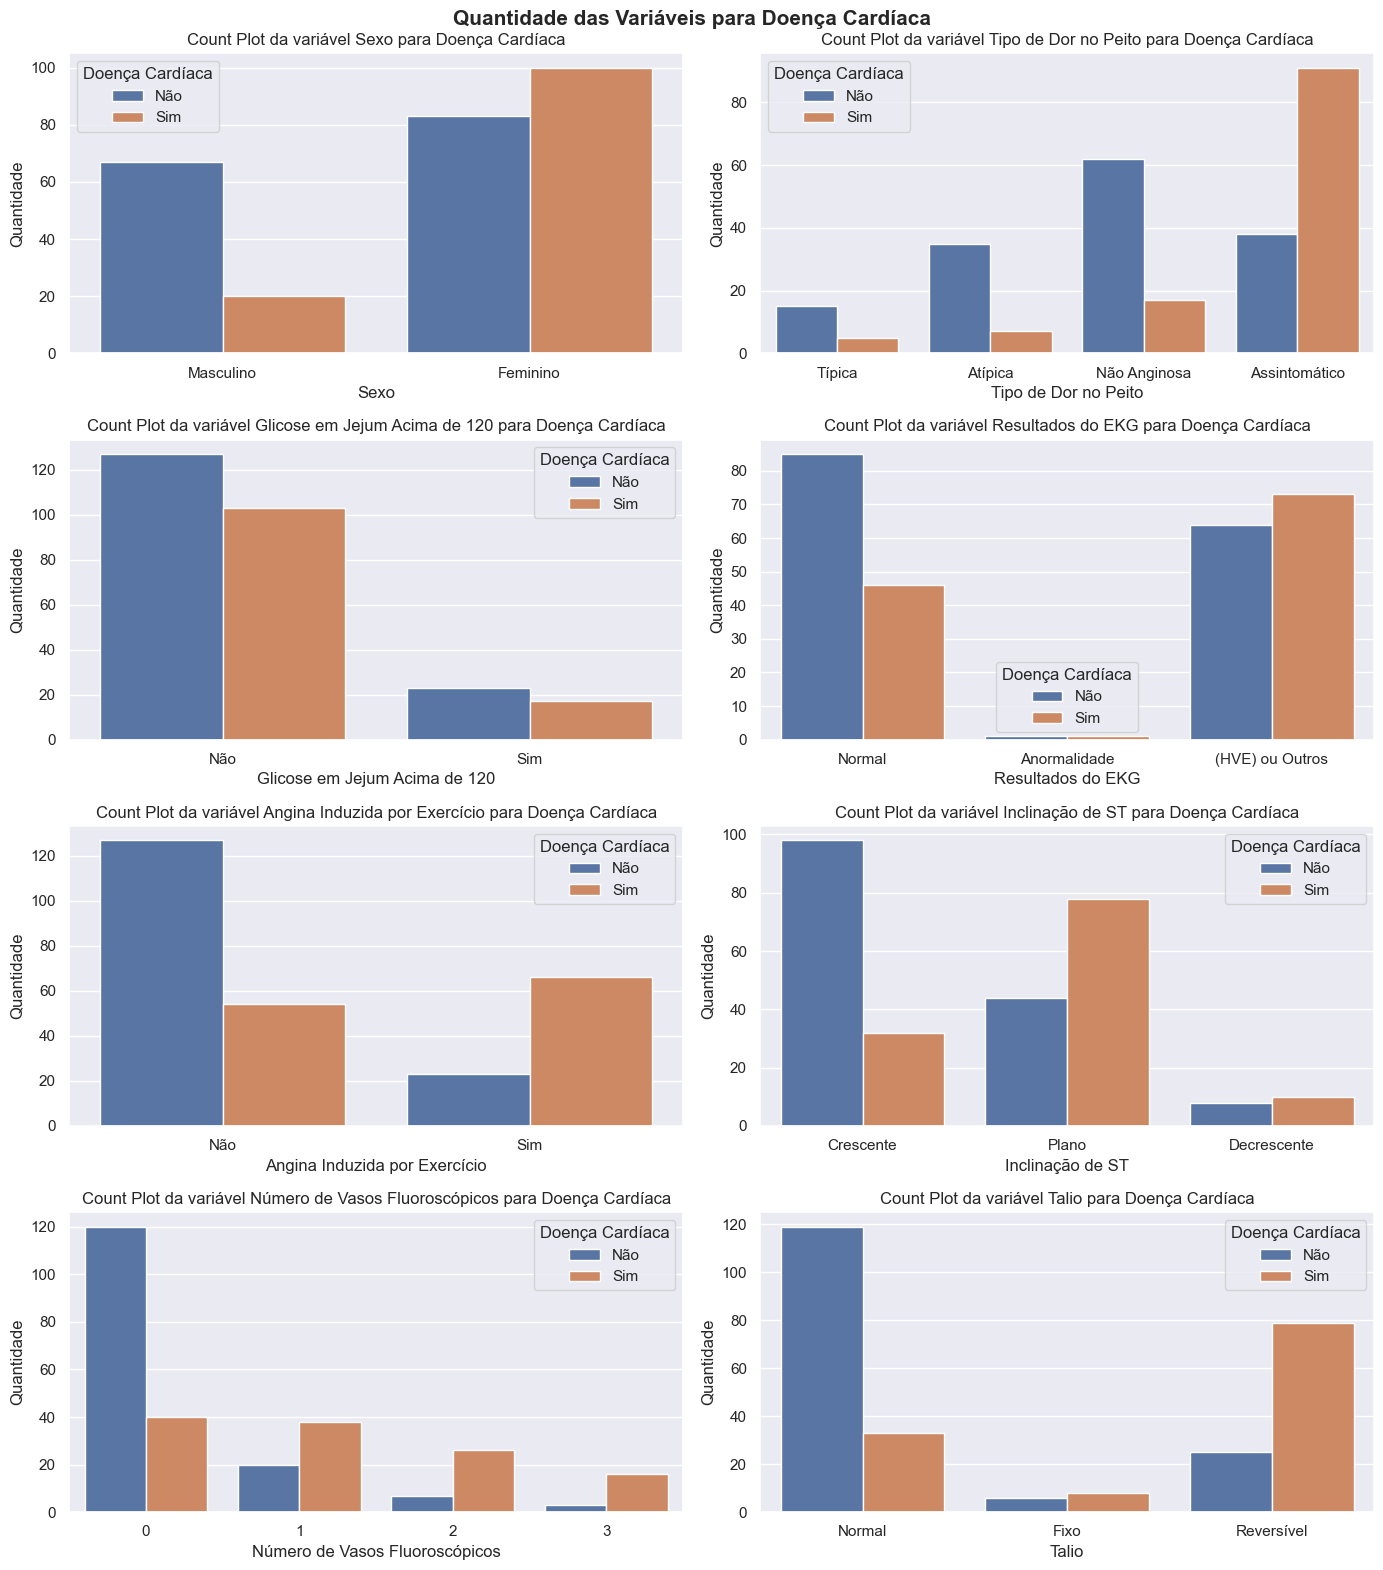

In [103]:
columns = ['sex', 'chest_pain_type', 'fbs_over_120', 'ekg_results', 
           'exercise_angina', 'slope_of_st', 'number_of_vessels_fluro', 'thallium']

xtick_names = [['Masculino','Feminino'],
               ['Típica','Atípica','Não Anginosa','Assintomático'],
               ['Não','Sim'],
               ['Normal','Anormalidade','(HVE) ou Outros'],
               ['Não','Sim'],
               ['Crescente','Plano','Decrescente'],
               [0,1,2,3],
               ['Normal', 'Fixo', 'Reversível']]

# Calculate the number of rows and columns for the subplots grid
n_rows = (len(columns) + 1) // 2  # Adjust for two columns per row

# Set up the figure and axes
fig, axes = plt.subplots(n_rows, 2, figsize=(14, 4 * n_rows))  # Adjust figsize as needed
axes = axes.flatten()  # Flatten the axes array for easy indexing

# Loop through each column and plot on a subplot
for i, col in enumerate(columns):
    sns.countplot(x=df[col], hue=df['heart_disease'], ax=axes[i])
    axes[i].set_xticklabels(xtick_names[i])
    axes[i].set_title(f'Count Plot da variável {columns_translated[col]} para Doença Cardíaca')
    axes[i].set_ylabel('Quantidade')
    axes[i].set_xlabel(columns_translated[col])
    axes[i].legend(title="Doença Cardíaca", labels=['Não', 'Sim'])

# Remove any empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])
    
plt.suptitle('Quantidade das Variáveis para Doença Cardíaca', fontsize=15, fontweight='bold')
    
plt.tight_layout()
# plt.savefig('plot_distruicao_count.png', dpi=300)
plt.show()

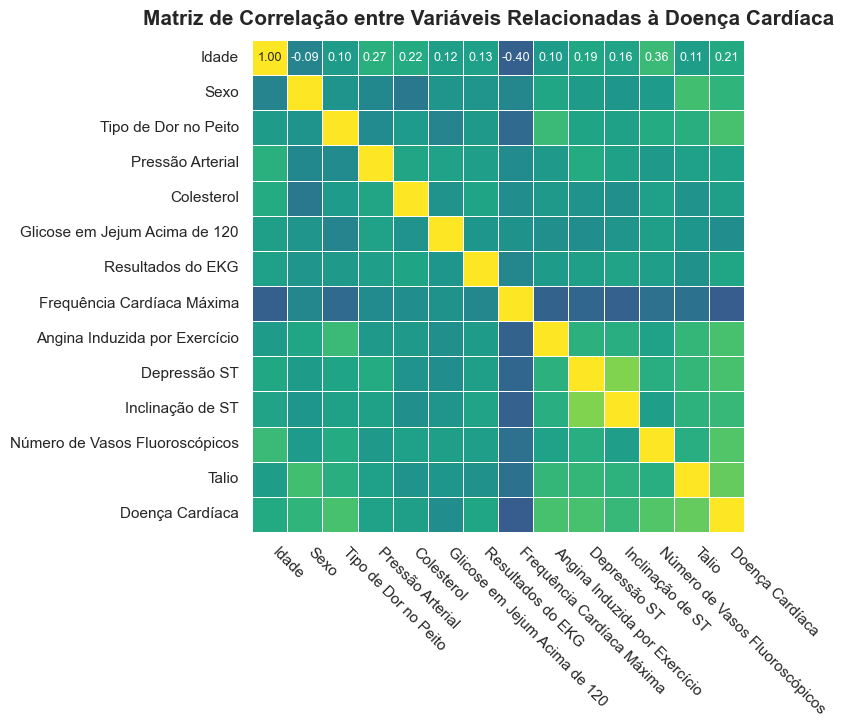

In [104]:
plt.figure(figsize = (8,6))
plt.rcParams.update({'font.size': 9})
translated_labels = [columns_translated.get(col, col) for col in df.columns]
sns.heatmap(df.corr(), cmap='viridis', vmin=-1, vmax=1, center=0, annot=True, fmt=".2f", 
            square=True, linewidths=0.5, 
            xticklabels=translated_labels, 
            yticklabels=translated_labels, cbar=False)
plt.suptitle("Matriz de Correlação entre Variáveis Relacionadas à Doença Cardíaca", fontsize=15, fontweight='bold')
plt.xticks(rotation=-45, ha='left')
plt.subplots_adjust(top=.93)
# plt.savefig('plot_distruicao_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

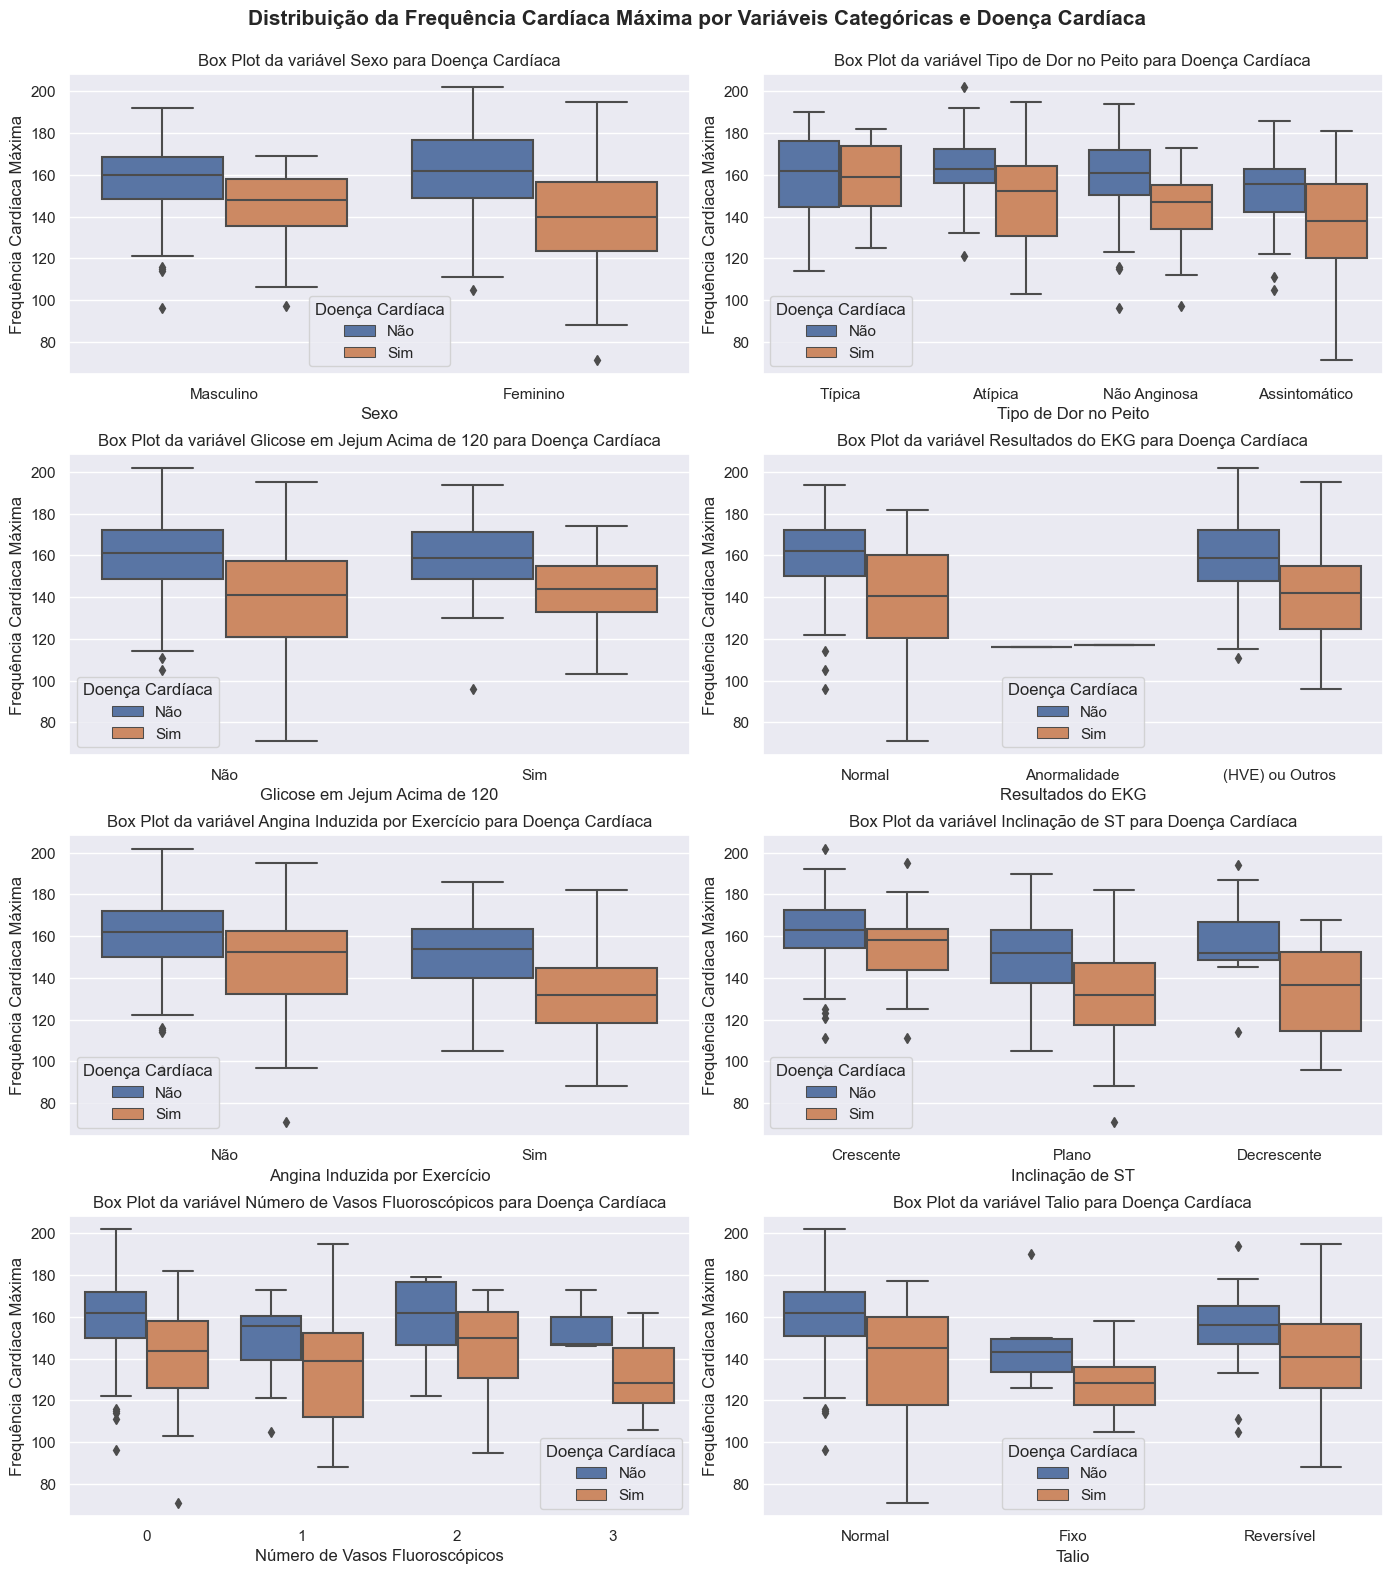

In [105]:
columns = ['sex', 'chest_pain_type', 'fbs_over_120', 'ekg_results', 
           'exercise_angina', 'slope_of_st', 'number_of_vessels_fluro', 'thallium']

# Calculate the number of rows and columns for the subplots grid
n_rows = (len(columns) + 1) // 2  # Adjust for two columns per row

# Set up the figure and axes
fig, axes = plt.subplots(n_rows, 2, figsize=(14, 4 * n_rows))  # Adjust figsize as needed
axes = axes.flatten()  # Flatten the axes array for easy indexing

# Loop through each column and plot on a subplot
for i, col in enumerate(columns):
    sns.boxplot(x=df[col],y=df['max_hr'], hue=df['heart_disease'], ax=axes[i])
    axes[i].set_xticklabels(xtick_names[i])
    axes[i].set_title(f'Box Plot da variável {columns_translated[col]} para Doença Cardíaca')
    axes[i].set_ylabel(columns_translated['max_hr'])
    axes[i].set_xlabel(columns_translated[col])
    handles, _ = axes[i].get_legend_handles_labels()
    axes[i].legend(handles=handles, title="Doença Cardíaca", labels=['Não', 'Sim'])

# Remove any empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])
    
plt.suptitle("Distribuição da Frequência Cardíaca Máxima por Variáveis Categóricas e Doença Cardíaca", fontsize=15, fontweight='bold')
plt.tight_layout()
plt.subplots_adjust(top=.94)
# plt.savefig('plot_distruicao_freq_Card.png', dpi=300)
plt.show()

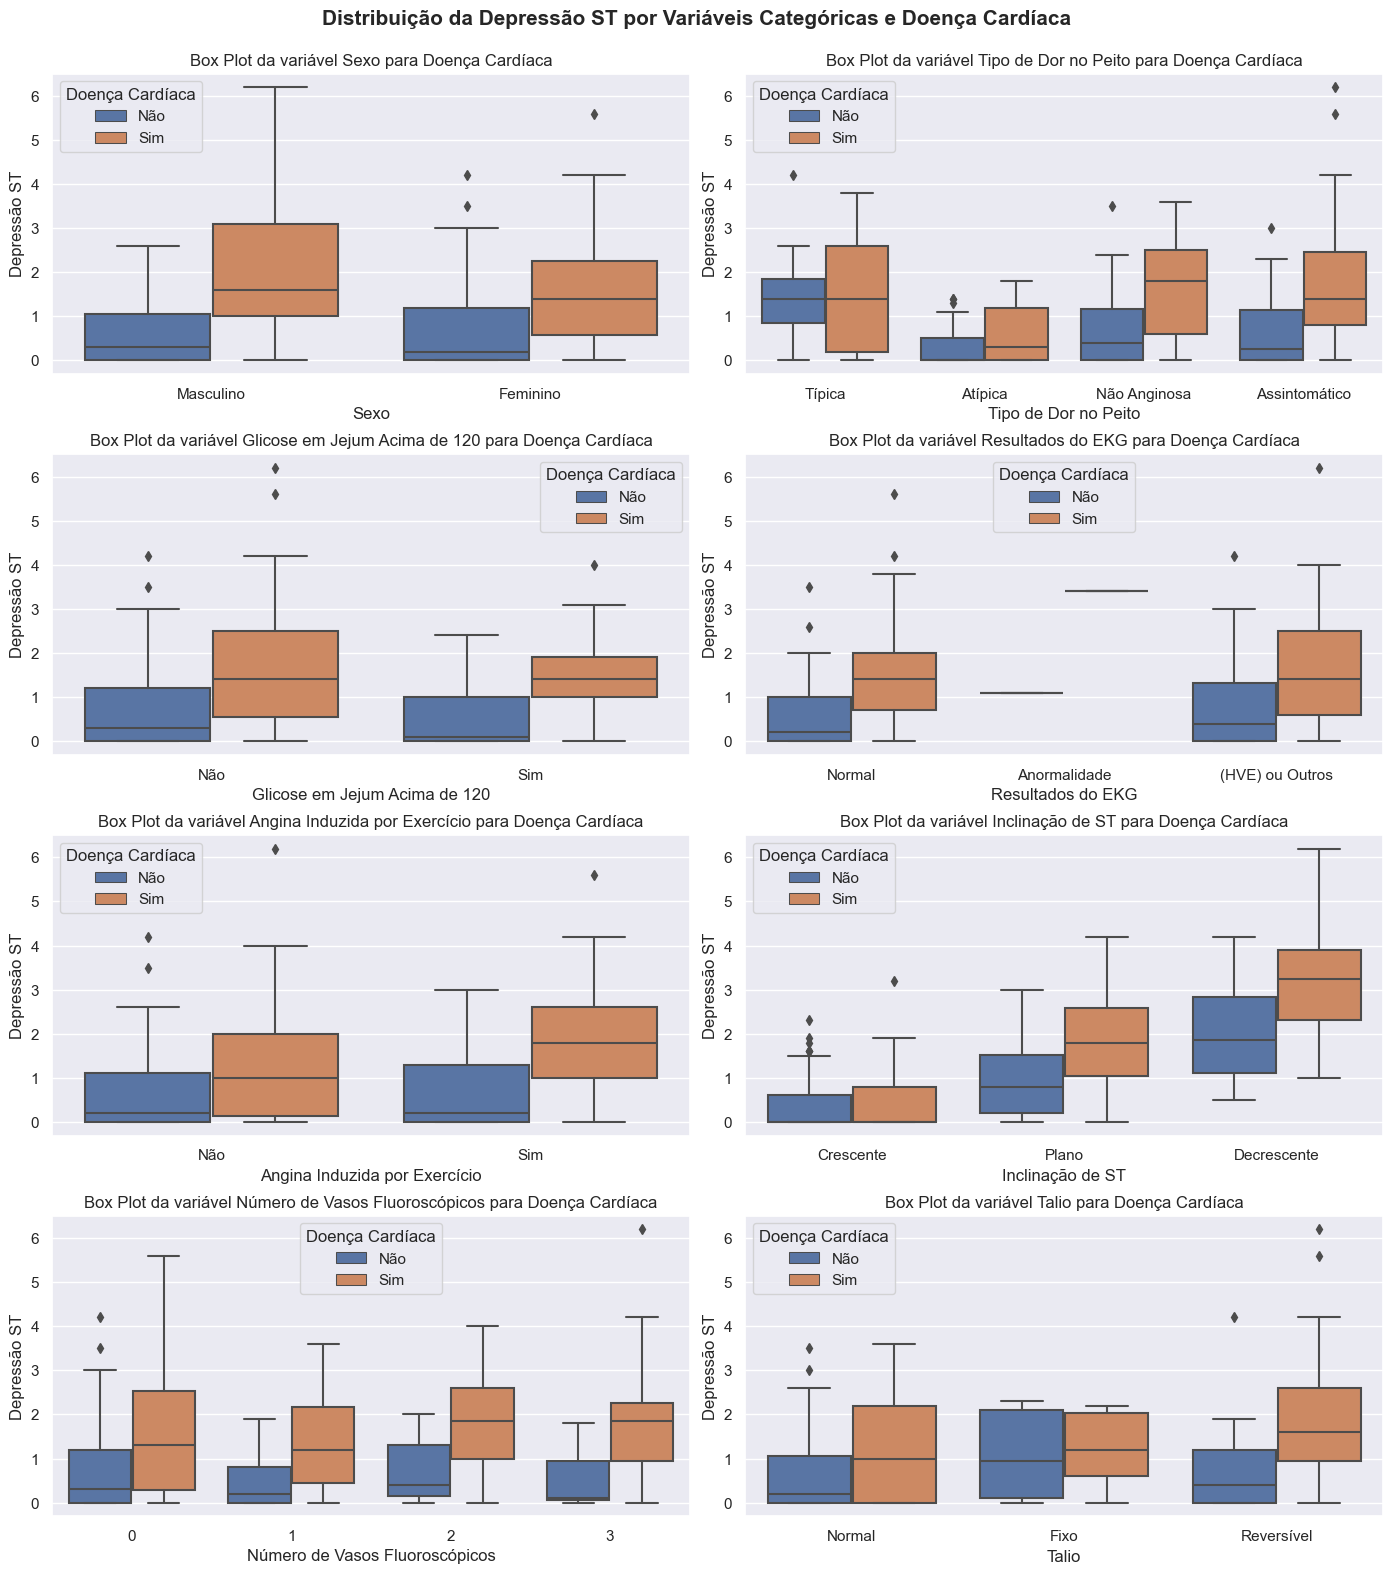

In [106]:
columns = ['sex', 'chest_pain_type', 'fbs_over_120', 'ekg_results', 
           'exercise_angina', 'slope_of_st', 'number_of_vessels_fluro', 'thallium']

# Calculate the number of rows and columns for the subplots grid
n_rows = (len(columns) + 1) // 2  # Adjust for two columns per row

# Set up the figure and axes
fig, axes = plt.subplots(n_rows, 2, figsize=(14, 4 * n_rows))  # Adjust figsize as needed
axes = axes.flatten()  # Flatten the axes array for easy indexing

# Loop through each column and plot on a subplot
for i, col in enumerate(columns):
    sns.boxplot(x=df[col],y=df['st_depression'], hue=df['heart_disease'], ax=axes[i])
    axes[i].set_xticklabels(xtick_names[i])
    axes[i].set_title(f'Box Plot da variável {columns_translated[col]} para Doença Cardíaca')
    axes[i].set_ylabel(columns_translated['st_depression'])
    axes[i].set_xlabel(columns_translated[col])
    handles, _ = axes[i].get_legend_handles_labels()
    axes[i].legend(handles=handles, title="Doença Cardíaca", labels=['Não', 'Sim'])

# Remove any empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])
    
plt.suptitle("Distribuição da Depressão ST por Variáveis Categóricas e Doença Cardíaca", fontsize=15, fontweight='bold')
plt.tight_layout()
plt.subplots_adjust(top=.94)
# plt.savefig('plot_distruicao_depresST.png', dpi=300)
plt.show()

## Criação de Train-Val-Test e Treinamento dos Modelos

In [ ]:
xtrain, xval, ytrain, yval = train_test_split(df.drop(columns='heart_disease'), df['heart_disease'], test_size=0.2, random_state=42)
xtrain, xtest, ytrain, ytest = train_test_split(xtrain, ytrain, test_size=0.2, random_state=42)
models = {}

In [30]:
def fitGrid(pipe,paramns,x,y):
    grid = GridSearchCV(estimator=pipe,param_grid=paramns,cv=5,n_jobs=4,scoring='recall', verbose=0)
    grid.fit(x,y)
    return grid.best_estimator_

def fitRandomizedGrid(pipe,paramns,x,y):
    grid = RandomizedSearchCV(estimator=pipe,param_distributions=paramns,cv=5,n_jobs=4,scoring='recall', verbose=0, random_state=42)
    grid.fit(x,y)
    return grid.best_estimator_

In [31]:
pipeline = Pipeline([('poly', PolynomialFeatures(3)),
                     ('pca', PCA(n_components=30)),
                     ('scaler', StandardScaler()),
                     ('logit', LogisticRegression())])

logit_params = {'logit__C':np.linspace(0.1,2,10)}

logit = fitRandomizedGrid(pipeline,logit_params,xtrain,ytrain)
y_pred = logit.predict(xtest)
recall_value = round(recall_score(ytest,y_pred),4)
models['logit'] = logit
print(recall_value)
print(classification_report(ytest,y_pred))

0.8333
              precision    recall  f1-score   support

           0       0.88      0.81      0.84        26
           1       0.75      0.83      0.79        18

    accuracy                           0.82        44
   macro avg       0.81      0.82      0.81        44
weighted avg       0.82      0.82      0.82        44



In [32]:
pipeline = Pipeline([('poly', PolynomialFeatures(3)),
                     ('pca', PCA(n_components=30)),
                     ('scaler', StandardScaler()),
                     ('svc', SVC())])

svc_params = {'svc__C':np.linspace(0.1,2,10),
              'svc__kernel':['linear', 'rbf', 'sigmoid',],
              'svc__gamma':np.linspace(0.1,2,10)}

svc = fitRandomizedGrid(pipeline,svc_params,xtrain,ytrain)
y_pred = svc.predict(xtest)
recall_value = recall_score(ytest,y_pred)
models['svc'] = svc
print(recall_value)
print(classification_report(ytest,y_pred))

0.8333333333333334
              precision    recall  f1-score   support

           0       0.88      0.81      0.84        26
           1       0.75      0.83      0.79        18

    accuracy                           0.82        44
   macro avg       0.81      0.82      0.81        44
weighted avg       0.82      0.82      0.82        44



In [33]:
pipeline = Pipeline([('poly', PolynomialFeatures(3)),
                    #  ('pca', PCA(n_components=30)),
                     ('scaler', StandardScaler()),
                     ('rf', RandomForestClassifier(random_state=42))])

rf_params = {'rf__n_estimators':np.linspace(50,300,25).astype('int'),
              'rf__max_depth':np.arange(1,15,2).astype('int')}

columns_translated_without_heart = list(columns_translated.values())[:-1]
print(columns_translated_without_heart)

# xtrain.columns = columns_translated_without_heart
# xtest.columns = columns_translated_without_heart

rf = fitRandomizedGrid(pipeline,rf_params,xtrain,ytrain)
y_pred = rf.predict(xtest)
recall_value = recall_score(ytest,y_pred)
models['rf'] = rf
print(recall_value)
print(classification_report(ytest,y_pred))

['Idade', 'Sexo', 'Tipo de Dor no Peito', 'Pressão Arterial', 'Colesterol', 'Glicose em Jejum Acima de 120', 'Resultados do EKG', 'Frequência Cardíaca Máxima', 'Angina Induzida por Exercício', 'Depressão ST', 'Inclinação de ST', 'Número de Vasos Fluoroscópicos', 'Talio']
0.8333333333333334
              precision    recall  f1-score   support

           0       0.87      0.77      0.82        26
           1       0.71      0.83      0.77        18

    accuracy                           0.80        44
   macro avg       0.79      0.80      0.79        44
weighted avg       0.81      0.80      0.80        44



In [23]:
recall_score(yval,rf.predict(xval))

0.8571428571428571

In [15]:
pipeline = Pipeline([('poly', PolynomialFeatures(3)),
                     ('pca', PCA(n_components=30)),
                     ('scaler', StandardScaler()),
                     ('knn', KNeighborsClassifier())])

knn_params = {'knn__n_neighbors':np.arange(3,10),
              'knn__weights':['uniform','distance']}

knn = fitRandomizedGrid(pipeline,knn_params,xtrain,ytrain)
y_pred = knn.predict(xtest)
recall_value = recall_score(ytest,y_pred)
models['knn'] = knn
print(recall_value)
print(classification_report(ytest,y_pred))

0.7222222222222222
              precision    recall  f1-score   support

           0       0.81      0.81      0.81        26
           1       0.72      0.72      0.72        18

    accuracy                           0.77        44
   macro avg       0.76      0.76      0.76        44
weighted avg       0.77      0.77      0.77        44



In [16]:
pipeline = Pipeline([('poly', PolynomialFeatures(3)),
                     ('pca', PCA(n_components=30)),
                     ('scaler', StandardScaler()),
                     ('cb', CatBoostClassifier(random_state=42, verbose=0))])

cb_params = {'cb__max_depth':np.arange(1,7,2)}

cb = fitRandomizedGrid(pipeline,cb_params,xtrain,ytrain)
y_pred = cb.predict(xtest)
recall_value = recall_score(ytest,y_pred)
models['cb'] = cb
print(recall_value)
print(classification_report(ytest,y_pred))

0.8333333333333334
              precision    recall  f1-score   support

           0       0.86      0.73      0.79        26
           1       0.68      0.83      0.75        18

    accuracy                           0.77        44
   macro avg       0.77      0.78      0.77        44
weighted avg       0.79      0.77      0.77        44



In [ ]:
# Com PCA
# for model in models.keys():
#     print(model,recall_score(yval,models[model].predict(xval)))
# logit 0.7619047619047619
# svc 0.6190476190476191
# rf 0.7142857142857143
# knn 0.6190476190476191
# cb 0.7619047619047619

In [17]:
# Sem PCA
temp = []
# xval.columns = columns_translated_without_heart
for model in models.keys():
    t = round(recall_score(yval,models[model].predict(xval)),3)
    temp.append(t)
    print(model,t)

logit 0.762
svc 0.619
rf 0.762
knn 0.619
cb 0.762


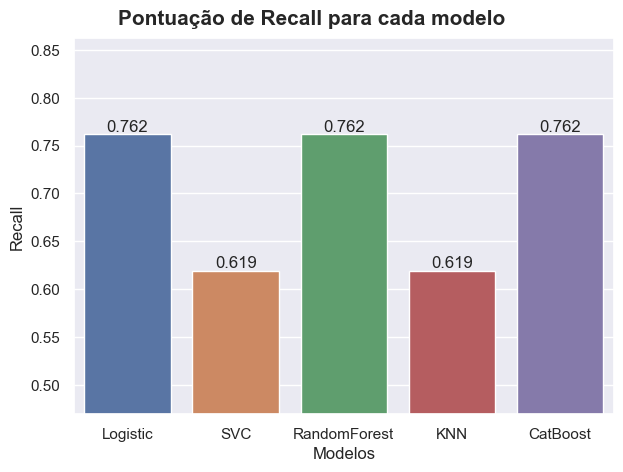

In [20]:
soft_colors = ['#4C72B0', '#DD8452', '#55A868', '#C44E52', '#8172B2']
ax = sns.barplot(x=['Logistic', 'SVC', 'RandomForest', 'KNN', 'CatBoost'], y=temp, palette=soft_colors)
plt.legend([], [], frameon=False)

for i, v in enumerate(temp):
    ax.text(i, v + 0.003, str(v), ha='center')

plt.xlabel("Modelos")
plt.ylabel("Recall")
plt.suptitle('Pontuação de Recall para cada modelo', fontsize=15, fontweight='bold')
plt.ylim(min(temp)-0.15,float(np.where(max(temp)+0.1 > 1,1,max(temp)+0.1)))
plt.tight_layout()
plt.subplots_adjust(top=.92)
# plt.savefig("recall_score_just_pca.png",dpi=300)
plt.show()

## Plots para RandomForest

In [ ]:
feature_importances = rf.named_steps['rf'].feature_importances_

# Get feature names from PolynomialFeatures
feature_names = rf.named_steps['poly'].get_feature_names_out(xtrain.columns)

# Create a DataFrame with feature names and their importances
feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importances
})

# Sort features by importance and select the top 10
top_features = feature_importance_df.sort_values(by='importance', ascending=False).head(10)
print("Top 10 most important features:")
print(top_features)

Top 10 most important features:
                                       feature  importance
140               age chest_pain_type thallium    0.023496
336       chest_pain_type slope_of_st thallium    0.019247
284                 chest_pain_type^2 thallium    0.017050
333     chest_pain_type st_depression thallium    0.015489
294                chest_pain_type bp thallium    0.015475
303       chest_pain_type cholesterol thallium    0.011723
339                 chest_pain_type thallium^2    0.011565
391                    bp slope_of_st thallium    0.011373
59                                 bp thallium    0.010784
331  chest_pain_type st_depression slope_of_st    0.010619


In [ ]:
bottom_features = feature_importance_df.sort_values(by='importance', ascending=False).tail(10)
print("Top 10 lest important features:")
print(bottom_features)

Top 10 lest important features:
                                      feature  importance
493      ekg_results exercise_angina thallium         0.0
491   ekg_results exercise_angina slope_of_st         0.0
489             ekg_results exercise_angina^2         0.0
73                 fbs_over_120 st_depression         0.0
406           cholesterol fbs_over_120 max_hr         0.0
407  cholesterol fbs_over_120 exercise_angina         0.0
75       fbs_over_120 number_of_vessels_fluro         0.0
478             ekg_results^2 exercise_angina         0.0
414   cholesterol ekg_results exercise_angina         0.0
0                                           1         0.0


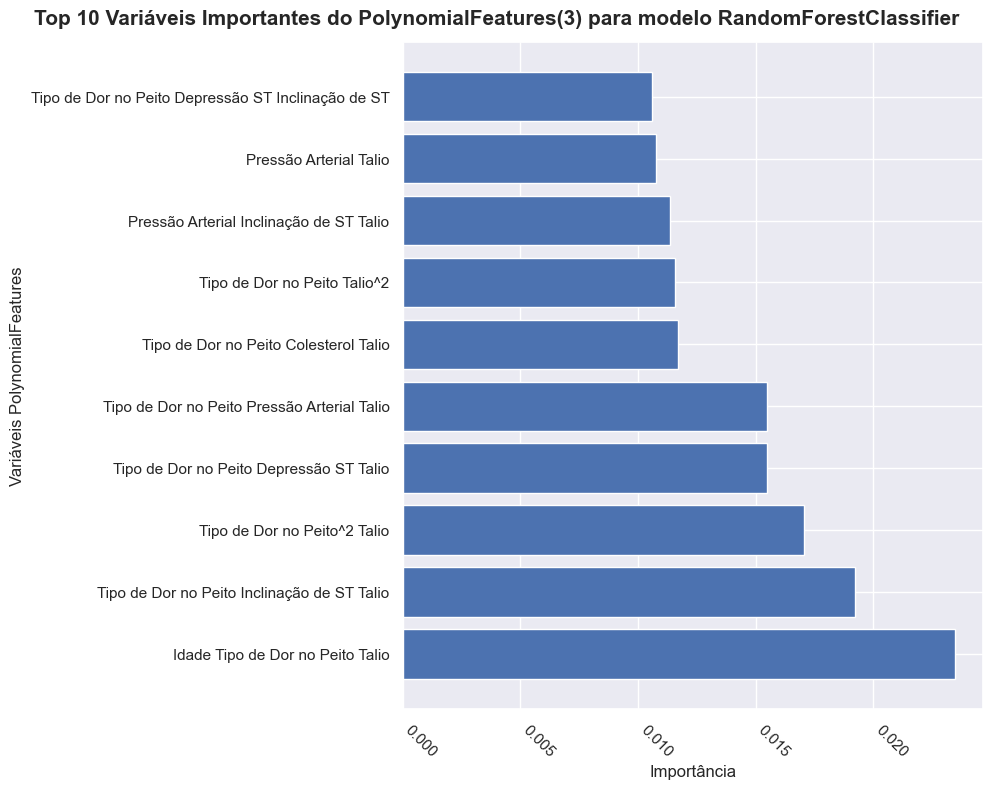

In [ ]:
plt.figure(figsize=(10, 8))
plt.barh(top_features['feature'], top_features['importance'])
plt.ylabel('Variáveis PolynomialFeatures')
plt.xlabel('Importância')
plt.xticks(rotation=90)
plt.xticks(rotation=-45, ha='left')
plt.suptitle("Top 10 Variáveis Importantes do PolynomialFeatures(3) para modelo RandomForestClassifier", fontsize=15, fontweight='bold')
plt.tight_layout()
plt.subplots_adjust(top=.94)
# plt.savefig('plot_rf_feature_importance_poly.png', dpi=300, bbox_inches='tight')
plt.show()

Index(['Idade', 'Sexo', 'Tipo de Dor no Peito', 'Pressão Arterial',
       'Colesterol', 'Glicose em Jejum Acima de 120', 'Resultados do EKG',
       'Frequência Cardíaca Máxima', 'Angina Induzida por Exercício',
       'Depressão ST', 'Inclinação de ST', 'Número de Vasos Fluoroscópicos',
       'Talio'],
      dtype='object')


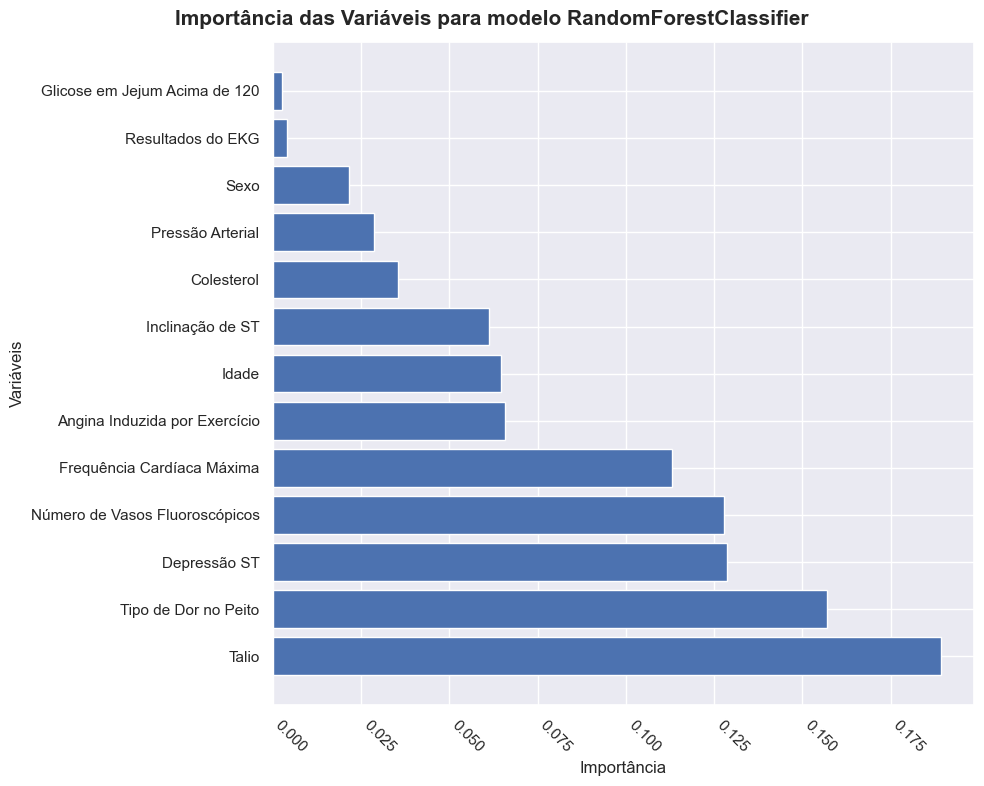

In [ ]:
importances = rf.named_steps['rf'].feature_importances_
features = xtrain.columns
print(features)
# translated_features = [columns_translated[feature] for feature in features]
feature_importances = sorted(zip(translated_features, importances), key=lambda x: x[1], reverse=True)
feature_names, feature_scores = zip(*feature_importances)

plt.figure(figsize=(10, 8))
plt.barh(feature_names, feature_scores)
plt.ylabel('Variáveis')
plt.xlabel('Importância')
plt.xticks(rotation=90)
plt.xticks(rotation=-45, ha='left')
plt.suptitle("Importância das Variáveis para modelo RandomForestClassifier", fontsize=15, fontweight='bold')
plt.tight_layout()
plt.subplots_adjust(top=.94)
# plt.savefig('plot_rf_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
df_temp = df.copy()

In [ ]:
df_temp['Idade*Tipo de Dor no Peito*Talio'] = df_temp['age']*df_temp['chest_pain_type']*df_temp['thallium']
df_temp['Tipo de Dor no Peito*Inclinacao ST*Talio'] = df_temp['chest_pain_type']*df_temp['slope_of_st']*df_temp['thallium']
df_temp['Tipo de Dor no Peito^2*Talio'] = np.square(df_temp['chest_pain_type'])*df_temp['thallium']
# cholesterol ekg_results exercise_angina
df_temp['Colesterol*Resultados EKG*Angina Induzida por Exercicio'] = df_temp['cholesterol']*df_temp['ekg_results']*df_temp['exercise_angina']


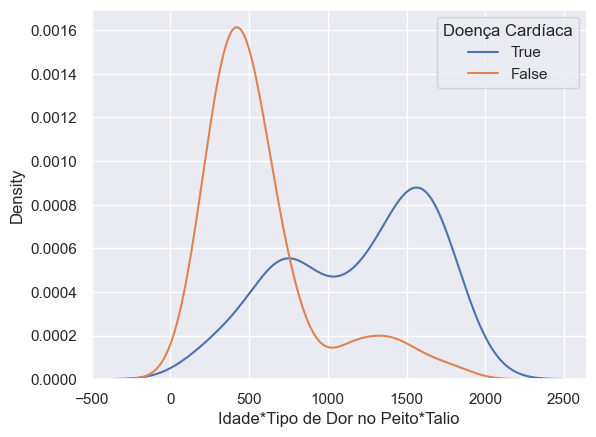

In [ ]:
sns.kdeplot(df_temp[df_temp['heart_disease'] == 1]['Idade*Tipo de Dor no Peito*Talio'], label='True')
sns.kdeplot(df_temp[df_temp['heart_disease'] == 0]['Idade*Tipo de Dor no Peito*Talio'], label='False')
plt.legend(title='Doença Cardíaca')

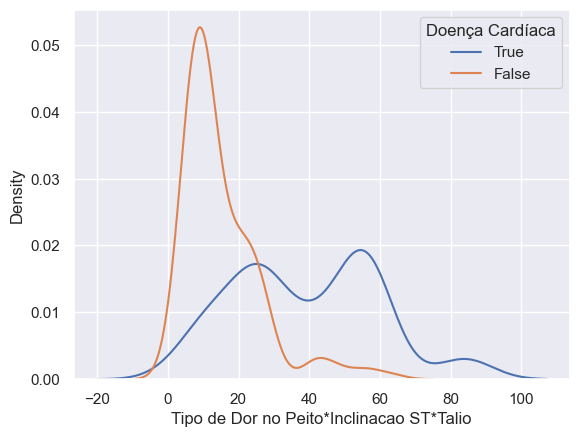

In [ ]:
sns.kdeplot(df_temp[df_temp['heart_disease'] == 1]['Tipo de Dor no Peito*Inclinacao ST*Talio'], label='True')
sns.kdeplot(df_temp[df_temp['heart_disease'] == 0]['Tipo de Dor no Peito*Inclinacao ST*Talio'], label='False')
plt.legend(title='Doença Cardíaca')

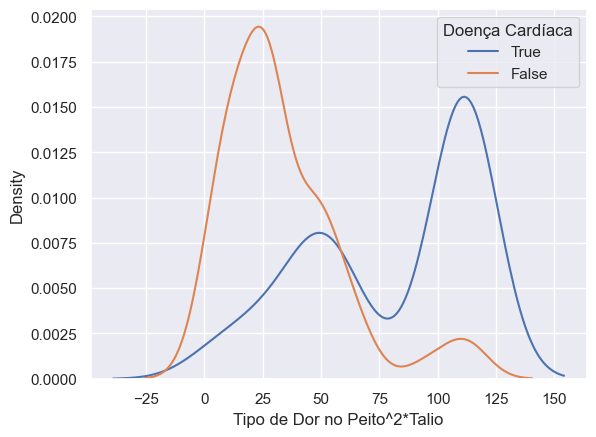

In [ ]:
sns.kdeplot(df_temp[df_temp['heart_disease'] == 1]['Tipo de Dor no Peito^2*Talio'], label='True')
sns.kdeplot(df_temp[df_temp['heart_disease'] == 0]['Tipo de Dor no Peito^2*Talio'], label='False')
plt.legend(title='Doença Cardíaca')

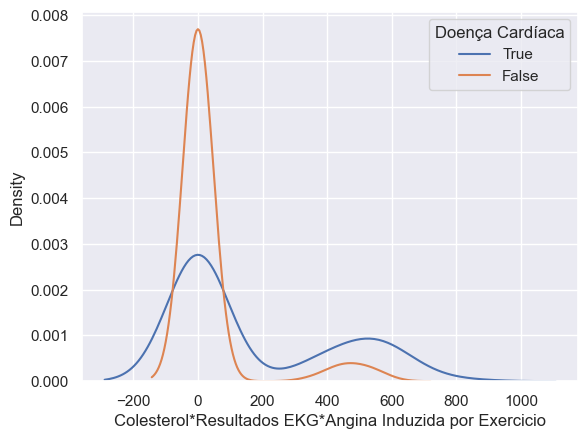

In [ ]:
sns.kdeplot(df_temp[df_temp['heart_disease'] == 1]['Colesterol*Resultados EKG*Angina Induzida por Exercicio'], label='True')
sns.kdeplot(df_temp[df_temp['heart_disease'] == 0]['Colesterol*Resultados EKG*Angina Induzida por Exercicio'], label='False')
plt.legend(title='Doença Cardíaca')

## Exportação do Modelo para Uso em API

In [ ]:
with open('rf.pkl', 'wb') as file:
    pickle.dump(models['rf'], file)